## 6.4 正則化
- 過学習とは、訓練データのみに適応しすぎてしまって訓練データに含まれない他のデータにうまく対応できない状態を言う
- 過学習を防止するために、**正則化**を行う

### 6.4.1 過学習
過学習が起きる原因として、主に2つがあげられる
- パラメータを大量に持ち、表現力が高いモデルであること
- 訓練データが少ないこと。

MNISTデータセットを元に、わざと過学習を発生させてみる。
- 訓練データ数：60000個$\rightarrow$300個
- ネットワークの層の数：3層$\rightarrow$7層
- 各層のニューロンの個数は全て100個、活性化関数はReLU

epoch:0, train acc:0.07666666666666666, test acc:0.0939
epoch:1, train acc:0.09, test acc:0.0953
epoch:2, train acc:0.09666666666666666, test acc:0.0994
epoch:3, train acc:0.12, test acc:0.1181
epoch:4, train acc:0.15666666666666668, test acc:0.135
epoch:5, train acc:0.19, test acc:0.1589
epoch:6, train acc:0.21, test acc:0.1801
epoch:7, train acc:0.24, test acc:0.2012
epoch:8, train acc:0.26666666666666666, test acc:0.219
epoch:9, train acc:0.2833333333333333, test acc:0.2352
epoch:10, train acc:0.31333333333333335, test acc:0.2576
epoch:11, train acc:0.34, test acc:0.2767
epoch:12, train acc:0.38666666666666666, test acc:0.3003
epoch:13, train acc:0.4033333333333333, test acc:0.3119
epoch:14, train acc:0.43, test acc:0.325
epoch:15, train acc:0.4533333333333333, test acc:0.3386
epoch:16, train acc:0.4766666666666667, test acc:0.3596
epoch:17, train acc:0.49666666666666665, test acc:0.3863
epoch:18, train acc:0.51, test acc:0.4103
epoch:19, train acc:0.5233333333333333, test acc:0.415

epoch:175, train acc:1.0, test acc:0.7512
epoch:176, train acc:1.0, test acc:0.7512
epoch:177, train acc:1.0, test acc:0.7505
epoch:178, train acc:1.0, test acc:0.7507
epoch:179, train acc:1.0, test acc:0.7526
epoch:180, train acc:1.0, test acc:0.7511
epoch:181, train acc:1.0, test acc:0.7528
epoch:182, train acc:1.0, test acc:0.7522
epoch:183, train acc:1.0, test acc:0.7525
epoch:184, train acc:1.0, test acc:0.7531
epoch:185, train acc:1.0, test acc:0.7524
epoch:186, train acc:1.0, test acc:0.7529
epoch:187, train acc:1.0, test acc:0.7532
epoch:188, train acc:1.0, test acc:0.7527
epoch:189, train acc:1.0, test acc:0.7537
epoch:190, train acc:1.0, test acc:0.7524
epoch:191, train acc:1.0, test acc:0.7527
epoch:192, train acc:1.0, test acc:0.7521
epoch:193, train acc:1.0, test acc:0.7525
epoch:194, train acc:1.0, test acc:0.7537
epoch:195, train acc:1.0, test acc:0.7535
epoch:196, train acc:1.0, test acc:0.7514
epoch:197, train acc:1.0, test acc:0.7522
epoch:198, train acc:1.0, test acc

<IPython.core.display.Javascript object>


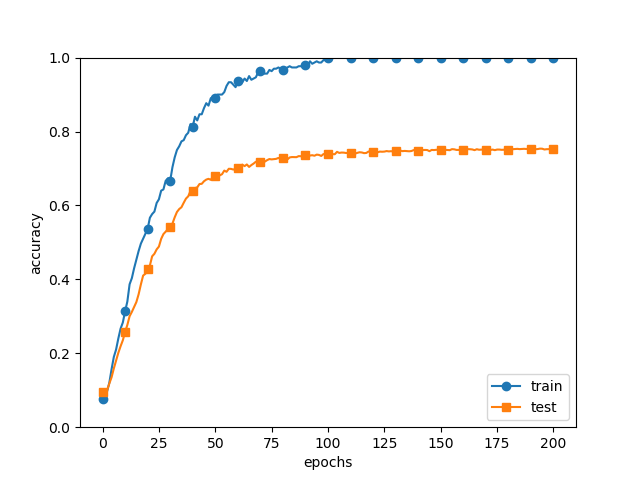

In [4]:
# coding: utf-8
%matplotlib notebook

import os
import sys

sys.path.append("../deep-learning-from-scratch/")  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
weight_decay_lambda = 0 # weight decayを使用しない場合
# weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- 100エポックをすぎたあたりで、訓練データによる認識精度はほぼ100%
- しかし、テストデータの認識精度は著しく低い。これは、モデルが汎化できていないことを意味する

### 6.4.2 Weight decay
過学習のためによく用いられる手法に、Weight decayがある。
- 学習の際に大きな重みを持つことに対してペナルティを課す
- 過学習は、重みパラメータが大きな値を取ることによって発生することが多い

重みをWとして、L2ノルムでのWeight decayは$\frac{1}{2}\lambda {\mathbf W} ^ 2$である。これを損失関数に加算する。

逆伝搬の際には。これまでの結果に$\frac{1}{2}\lambda {\mathbf W} ^ 2$の微分$\lambda {\mathbf W}$を加算する。

epoch:0, train acc:0.11, test acc:0.0829
epoch:1, train acc:0.13333333333333333, test acc:0.0897
epoch:2, train acc:0.17666666666666667, test acc:0.1055
epoch:3, train acc:0.18333333333333332, test acc:0.1308
epoch:4, train acc:0.23, test acc:0.1453
epoch:5, train acc:0.2733333333333333, test acc:0.1662
epoch:6, train acc:0.3333333333333333, test acc:0.1889
epoch:7, train acc:0.33, test acc:0.2027
epoch:8, train acc:0.35333333333333333, test acc:0.2248
epoch:9, train acc:0.38666666666666666, test acc:0.2449
epoch:10, train acc:0.41333333333333333, test acc:0.2785
epoch:11, train acc:0.48, test acc:0.298
epoch:12, train acc:0.4866666666666667, test acc:0.3174
epoch:13, train acc:0.47, test acc:0.308
epoch:14, train acc:0.47333333333333333, test acc:0.3251
epoch:15, train acc:0.48333333333333334, test acc:0.3442
epoch:16, train acc:0.49666666666666665, test acc:0.3639
epoch:17, train acc:0.52, test acc:0.3834
epoch:18, train acc:0.5633333333333334, test acc:0.3979
epoch:19, train acc:0.5

epoch:162, train acc:0.9033333333333333, test acc:0.7174
epoch:163, train acc:0.8866666666666667, test acc:0.7132
epoch:164, train acc:0.92, test acc:0.7261
epoch:165, train acc:0.92, test acc:0.7215
epoch:166, train acc:0.9133333333333333, test acc:0.7198
epoch:167, train acc:0.9033333333333333, test acc:0.717
epoch:168, train acc:0.9066666666666666, test acc:0.7181
epoch:169, train acc:0.9166666666666666, test acc:0.723
epoch:170, train acc:0.9066666666666666, test acc:0.7157
epoch:171, train acc:0.9133333333333333, test acc:0.7251
epoch:172, train acc:0.9266666666666666, test acc:0.725
epoch:173, train acc:0.9166666666666666, test acc:0.7246
epoch:174, train acc:0.8933333333333333, test acc:0.7138
epoch:175, train acc:0.8966666666666666, test acc:0.7162
epoch:176, train acc:0.8833333333333333, test acc:0.7107
epoch:177, train acc:0.9033333333333333, test acc:0.7187
epoch:178, train acc:0.9066666666666666, test acc:0.7243
epoch:179, train acc:0.8966666666666666, test acc:0.7131
epoch

<IPython.core.display.Javascript object>


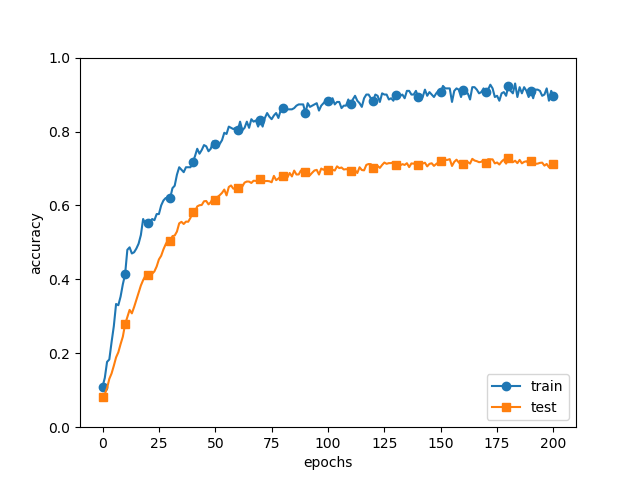

In [3]:
# coding: utf-8
%matplotlib notebook

import os
import sys

sys.path.append("../deep-learning-from-scratch/")  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
# weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

先ほどと比較すると、
- 訓練データとテストデータの認識精度の隔たりが小さい。
- 訓練データの認識精度が100%になっていない。
ため、過学習が抑制されていると言える。

### 6.4.3 Dropout
- Weight decayは、比較的簡単に実装できるが、これだけでは対応が困難になる場合がある
- Dropoutは、ニューロンをランダムに消去しながら学習する手法である。

これは、過学習の2つの原因のうち「モデルの表現力」を抑制している

train loss:2.326370081510464
=== epoch:1, train acc:0.08666666666666667, test acc:0.0986 ===
train loss:2.308837811981962
train loss:2.306136341350721
train loss:2.3359609186000485
=== epoch:2, train acc:0.08666666666666667, test acc:0.0997 ===
train loss:2.318786671685929
train loss:2.314849554045238
train loss:2.301104014762859
=== epoch:3, train acc:0.08333333333333333, test acc:0.0988 ===
train loss:2.327098265147154
train loss:2.325451542658287
train loss:2.322234473225034
=== epoch:4, train acc:0.09, test acc:0.0992 ===
train loss:2.3164954700312683
train loss:2.3342627268250813
train loss:2.3069053896806535
=== epoch:5, train acc:0.09, test acc:0.1025 ===
train loss:2.321218877253866
train loss:2.333166457391832
train loss:2.3217256197551746
=== epoch:6, train acc:0.09, test acc:0.1047 ===
train loss:2.3123547490500123
train loss:2.3114006971969014
train loss:2.311388994184219
=== epoch:7, train acc:0.10333333333333333, test acc:0.1102 ===
train loss:2.3057746866762305
train los

train loss:2.2650971113896747
=== epoch:56, train acc:0.25333333333333335, test acc:0.2208 ===
train loss:2.26258959325065
train loss:2.263228722605878
train loss:2.257884981841429
=== epoch:57, train acc:0.26666666666666666, test acc:0.2267 ===
train loss:2.2607528042719984
train loss:2.2671765931349395
train loss:2.260043920531173
=== epoch:58, train acc:0.2633333333333333, test acc:0.2259 ===
train loss:2.2586208355502255
train loss:2.2685252854387388
train loss:2.254194908719015
=== epoch:59, train acc:0.26, test acc:0.227 ===
train loss:2.2593167436905177
train loss:2.260771547720745
train loss:2.255572733620854
=== epoch:60, train acc:0.27666666666666667, test acc:0.2354 ===
train loss:2.2503284713761467
train loss:2.2694885570971706
train loss:2.2560868866416155
=== epoch:61, train acc:0.2733333333333333, test acc:0.2367 ===
train loss:2.267606268316784
train loss:2.2621048966691233
train loss:2.253988993393758
=== epoch:62, train acc:0.27666666666666667, test acc:0.2408 ===
tra

train loss:2.224550884343888
=== epoch:112, train acc:0.38333333333333336, test acc:0.3344 ===
train loss:2.2264303882045398
train loss:2.2145710212769223
train loss:2.213690979221432
=== epoch:113, train acc:0.38666666666666666, test acc:0.3379 ===
train loss:2.221771296286056
train loss:2.201278800700622
train loss:2.229923359824849
=== epoch:114, train acc:0.39, test acc:0.3387 ===
train loss:2.2060854244408783
train loss:2.2014932527304225
train loss:2.217193159081266
=== epoch:115, train acc:0.4066666666666667, test acc:0.3435 ===
train loss:2.237768387952533
train loss:2.201669938979515
train loss:2.1811004604798985
=== epoch:116, train acc:0.4, test acc:0.3409 ===
train loss:2.2182883122901584
train loss:2.2143142515035477
train loss:2.204345159746075
=== epoch:117, train acc:0.4166666666666667, test acc:0.348 ===
train loss:2.2068110684840776
train loss:2.2079308187178883
train loss:2.2163196935284675
=== epoch:118, train acc:0.44, test acc:0.3505 ===
train loss:2.2207320764690

=== epoch:168, train acc:0.5033333333333333, test acc:0.3906 ===
train loss:2.1077804924353605
train loss:2.104805935712985
train loss:2.099409913553204
=== epoch:169, train acc:0.51, test acc:0.396 ===
train loss:2.0619274246661083
train loss:2.0565062628774964
train loss:2.0496383747741267
=== epoch:170, train acc:0.51, test acc:0.3934 ===
train loss:2.0693035272084184
train loss:2.0738560779309188
train loss:2.0837944828128583
=== epoch:171, train acc:0.5066666666666667, test acc:0.3946 ===
train loss:2.048359652099981
train loss:2.098967093270108
train loss:2.0978069308079696
=== epoch:172, train acc:0.5033333333333333, test acc:0.3958 ===
train loss:2.05618186268225
train loss:2.0863294282681655
train loss:2.055509457202752
=== epoch:173, train acc:0.5, test acc:0.3957 ===
train loss:2.037708891521399
train loss:2.0520293886063365
train loss:2.029002270117908
=== epoch:174, train acc:0.51, test acc:0.3992 ===
train loss:2.0405288195537867
train loss:2.0666762435167647
train loss:2

=== epoch:224, train acc:0.6133333333333333, test acc:0.469 ===
train loss:1.7457055361846612
train loss:1.752216250895039
train loss:1.7768658629773235
=== epoch:225, train acc:0.6033333333333334, test acc:0.4727 ===
train loss:1.7063771774101437
train loss:1.7283655711974857
train loss:1.683301448543054
=== epoch:226, train acc:0.6133333333333333, test acc:0.4764 ===
train loss:1.754897256516688
train loss:1.7604896485473427
train loss:1.7435714418703971
=== epoch:227, train acc:0.6033333333333334, test acc:0.4722 ===
train loss:1.7480353579042642
train loss:1.764258008980504
train loss:1.7604417606322726
=== epoch:228, train acc:0.61, test acc:0.4812 ===
train loss:1.5786027663309707
train loss:1.7005824189285916
train loss:1.6889981694877938
=== epoch:229, train acc:0.61, test acc:0.4879 ===
train loss:1.6501102334275148
train loss:1.6461915596448404
train loss:1.7745545995972944
=== epoch:230, train acc:0.63, test acc:0.4921 ===
train loss:1.6726899779418818
train loss:1.716867820

=== epoch:280, train acc:0.6966666666666667, test acc:0.5581 ===
train loss:1.2747642416089233
train loss:1.2376416307046194
train loss:1.4356831583064524
=== epoch:281, train acc:0.7, test acc:0.5678 ===
train loss:1.3238347320473216
train loss:1.1816294399523988
train loss:1.314558834527106
=== epoch:282, train acc:0.7133333333333334, test acc:0.5716 ===
train loss:1.3449210298089225
train loss:1.276871773666044
train loss:1.30184885221659
=== epoch:283, train acc:0.7133333333333334, test acc:0.5695 ===
train loss:1.1773578219264982
train loss:1.4018668861149326
train loss:1.273987617804091
=== epoch:284, train acc:0.6933333333333334, test acc:0.5617 ===
train loss:1.3041302443284764
train loss:1.2614710258704647
train loss:1.3031444657266364
=== epoch:285, train acc:0.6966666666666667, test acc:0.5604 ===
train loss:1.2777735537404553
train loss:1.228842135842589
train loss:1.1964299022060734
=== epoch:286, train acc:0.69, test acc:0.5589 ===
train loss:1.2059509726844508
train loss

train loss:0.9406132768246225
=== epoch:335, train acc:0.6933333333333334, test acc:0.5681 ===
train loss:0.9423715078656862
train loss:0.9539985565956141
train loss:0.8124066781659373
=== epoch:336, train acc:0.7, test acc:0.5794 ===
train loss:1.030604213537317
train loss:0.9554141296649449
train loss:0.7823798410301176
=== epoch:337, train acc:0.71, test acc:0.5818 ===
train loss:0.8310319061677334
train loss:0.9522231076284724
train loss:0.8495253044883515
=== epoch:338, train acc:0.69, test acc:0.5695 ===
train loss:0.9643461891933721
train loss:0.839274046217901
train loss:0.965982252770393
=== epoch:339, train acc:0.69, test acc:0.5642 ===
train loss:0.9415972672922547
train loss:0.9857774842941822
train loss:0.9538625506116278
=== epoch:340, train acc:0.6833333333333333, test acc:0.5596 ===
train loss:1.059322964287078
train loss:0.9298499349229323
train loss:0.842540059261088
=== epoch:341, train acc:0.6833333333333333, test acc:0.5588 ===
train loss:1.059659934962336
train lo

=== epoch:390, train acc:0.7166666666666667, test acc:0.5841 ===
train loss:0.7707836669824298
train loss:0.7743865245236122
train loss:0.8125837883488175
=== epoch:391, train acc:0.7366666666666667, test acc:0.592 ===
train loss:0.7567696310611158
train loss:0.6584363670762954
train loss:0.8400323448090465
=== epoch:392, train acc:0.7466666666666667, test acc:0.6081 ===
train loss:0.7315819397405008
train loss:0.7839296768277747
train loss:0.7028262893205762
=== epoch:393, train acc:0.7466666666666667, test acc:0.6075 ===
train loss:0.7974089272824106
train loss:0.7473584674230429
train loss:0.7176242019317014
=== epoch:394, train acc:0.7533333333333333, test acc:0.6229 ===
train loss:0.7032187049967152
train loss:0.7096509161941866
train loss:0.8585363669147715
=== epoch:395, train acc:0.7733333333333333, test acc:0.6227 ===
train loss:0.7139623803632434
train loss:0.8414321273240559
train loss:0.6994132151477117
=== epoch:396, train acc:0.77, test acc:0.6266 ===
train loss:0.7391035

train loss:0.6217409262041287
train loss:0.5201576582362721
train loss:0.5741694719653142
=== epoch:445, train acc:0.7766666666666666, test acc:0.6559 ===
train loss:0.6849179958052314
train loss:0.6176509590058731
train loss:0.6853179768855049
=== epoch:446, train acc:0.79, test acc:0.6526 ===
train loss:0.5290034232726437
train loss:0.6529671896849671
train loss:0.6625267716042249
=== epoch:447, train acc:0.78, test acc:0.6569 ===
train loss:0.5697220279943574
train loss:0.6683038316728837
train loss:0.5876209155422166
=== epoch:448, train acc:0.7833333333333333, test acc:0.6568 ===
train loss:0.5940015688273833
train loss:0.6279144131804869
train loss:0.6313805721467809
=== epoch:449, train acc:0.79, test acc:0.6471 ===
train loss:0.6341435849518412
train loss:0.5173906091604273
train loss:0.5784479432447255
=== epoch:450, train acc:0.79, test acc:0.6497 ===
train loss:0.5746264378826055
train loss:0.5982273342423183
train loss:0.6423767549262993
=== epoch:451, train acc:0.79, test 

=== epoch:500, train acc:0.8333333333333334, test acc:0.671 ===
train loss:0.5118473733308917
train loss:0.37540949226502657
train loss:0.5526095896283786
=== epoch:501, train acc:0.8333333333333334, test acc:0.6684 ===
train loss:0.376353820111229
train loss:0.36826999158722584
train loss:0.5086957763208967
=== epoch:502, train acc:0.8266666666666667, test acc:0.6656 ===
train loss:0.45009590702731217
train loss:0.3410932803230098
train loss:0.46295022727718177
=== epoch:503, train acc:0.8233333333333334, test acc:0.6659 ===
train loss:0.4963038196248823
train loss:0.4941761483851104
train loss:0.4714283679791024
=== epoch:504, train acc:0.8266666666666667, test acc:0.6707 ===
train loss:0.6460541922769526
train loss:0.49530322288777107
train loss:0.5136385963662
=== epoch:505, train acc:0.84, test acc:0.6711 ===
train loss:0.4797856468680268
train loss:0.4828929866143514
train loss:0.41287417719372566
=== epoch:506, train acc:0.83, test acc:0.6784 ===
train loss:0.490830389483811
tra

train loss:0.45480100939217216
=== epoch:555, train acc:0.8566666666666667, test acc:0.6948 ===
train loss:0.43458782121786255
train loss:0.47644207911376246
train loss:0.3547531310365617
=== epoch:556, train acc:0.8666666666666667, test acc:0.6943 ===
train loss:0.3440039481460902
train loss:0.3600716379538688
train loss:0.32898060986289246
=== epoch:557, train acc:0.8766666666666667, test acc:0.6944 ===
train loss:0.35247058565594214
train loss:0.47035045964933464
train loss:0.40214465938060845
=== epoch:558, train acc:0.8766666666666667, test acc:0.6944 ===
train loss:0.3474034509960678
train loss:0.32795831196317954
train loss:0.3386686870687271
=== epoch:559, train acc:0.8733333333333333, test acc:0.6981 ===
train loss:0.4005285920482131
train loss:0.4507401735412262
train loss:0.3518356947158133
=== epoch:560, train acc:0.8733333333333333, test acc:0.6964 ===
train loss:0.4283962205268893
train loss:0.38901890739372497
train loss:0.41695724148667934
=== epoch:561, train acc:0.87,

<IPython.core.display.Javascript object>


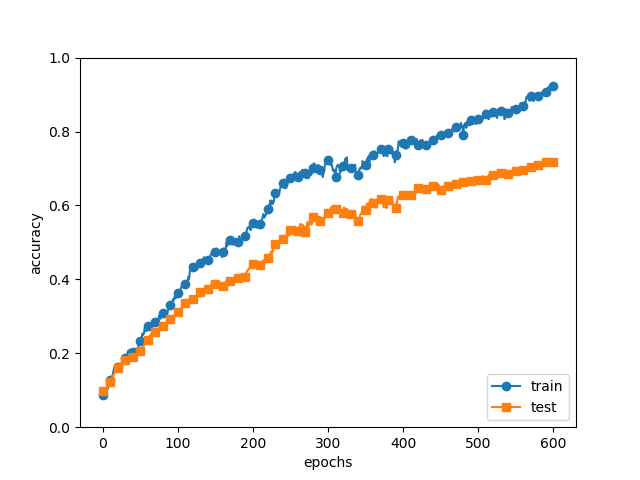

In [6]:
# coding: utf-8
%matplotlib notebook
import os
import sys
sys.path.append("../deep-learning-from-scratch/")  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=601, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

Dropoutは、アンサンブル学習と考え方が似ている。